In [1]:
using Enzyme, Plots, HDF5, LinearAlgebra, LineSearches, Optim, LaTeXStrings

In [2]:
default(fontfamily="Computer Modern",guidefontsize=16,tickfontsize=13,legendfontsize=13)

In [3]:
struct setup
    # Model set-up parameters
    N_t::Int64
    dt::Float64
    K::Int64
    F::Float64
    
    # Model observation
    XFO::Vector{Float64}
end

mutable struct ctrl_state
    # Model control parameters
    X0::Vector{Float64}
    
    # Variables
    X::Vector{Float64}
    dX::Vector{Float64}
    dXm1::Vector{Float64}
    dXm2::Vector{Float64}
    
    # Data in time array
    X_array::Matrix{Float64}
end

In [4]:
function init(N_t, dt, K, F, FXO, X0)
    # Memory allocation
    X = zeros(Float64, K)
    dX = zeros(Float64, K)
    dXm1 = zeros(Float64, K)
    dXm2 = zeros(Float64, K)
    X_array = zeros(Float64, K, N_t+1)

    # Set intial conditions in X and X_array
    X .= X0
    X_array[:, 1] = X0
    
    # Initialize structs
    su = setup(N_t, dt, K, F, XFO)
    cs = ctrl_state(X0, X, dX, dXm1, dXm2, X_array)
    
    return su, cs
end

init (generic function with 1 method)

In [5]:
# dX rhs
function dXrhs(k, X)
    dXk = - X[k - 1] * (X[k - 2] - X[k + 1]) - X[k] + F
    return dXk
end

# Euler step
function euler_step(dt, K, F, X, dX, dXm1, dXm2)
    # Compute derivatives
    dX[1] = - X[K] * (X[K - 1] - X[2]) - X[1] + F
    dX[2] = - X[1] * (X[K] - X[3]) - X[2] + F
    dX[K] = - X[K - 1] * (X[K - 2] - X[1]) - X[K] + F
    
    # Update X
    X[1] += dt * dX[1]
    X[2] += dt * dX[2]
    X[K] += dt * dX[3]
    for k = 3:K-1
        dX[k] = dXrhs(k, X)
        X[k] += dt * dX[k]
    end

    # Update dXs
    dXm1 .= dX
    dXm2 .= dXm1
    
    return X, dX, dXm1, dXm2
end

# AB-3 rhs
function adams_bashforth3(x, dt, dx, dxm1, dxm2)
    rhs = x + dt * ((23/12) * dx 
            - (16/12) * dxm1
            + (5/12) * dxm2)
    return rhs
end

# AB-3 step
function ab3_step(dt, K, F, X, dX, dXm1, dXm2)
    # Compute derivatives
    dX[1] = - X[K] * (X[K - 1] - X[2]) - X[1] + F
    dX[2] = - X[1] * (X[K] - X[3]) - X[2] + F
    dX[K] = - X[K - 1] * (X[K - 2] - X[1]) - X[K] + F
    
    
    # Update X
    X[1] = adams_bashforth3(X[1], dt, dX[1], dXm1[1], dXm2[1])
    X[2] = adams_bashforth3(X[2], dt, dX[2], dXm1[2], dXm2[2])
    X[K] = adams_bashforth3(X[K], dt, dX[K], dXm1[K], dXm2[K])
    for k = 3:K-1
        dX[k] = dXrhs(k, X)
        X[k] = adams_bashforth3(X[k], dt, dX[k], dXm1[k], dXm2[k])
    end

    # Update dXs
    dXm1 .= dX
    dXm2 .= dXm1
    
    return X, dX, dXm1, dXm2
end

ab3_step (generic function with 1 method)

In [6]:
function forward_model(su, cs)
    for step in 1:2
        euler_step(su.dt, su.K, su.F, cs.X, cs.dX, cs.dXm1, cs.dXm2)
        cs.X_array[:, step+1] = cs.X
    end

    for step in 3:su.N_t
        ab3_step(su.dt, su.K, su.F, cs.X, cs.dX, cs.dXm1, cs.dXm2)
        cs.X_array[:, step+1] = cs.X
    end
    
    return nothing
end

forward_model (generic function with 1 method)

In [21]:
X0 = [ -4.5, 2.0, 5.6, 13.8]
XFO = [2.32, 2.25, 15.48, -1.96] .+ 0.1

# Model parameters
N_t = 150
dt = 0.001
ts = range(; start=0, step = dt, length=N_t+1)
K = 4
F = 20.

SU, CS = init(N_t, dt, K, F, XFO, X0)

forward_model(SU, CS)

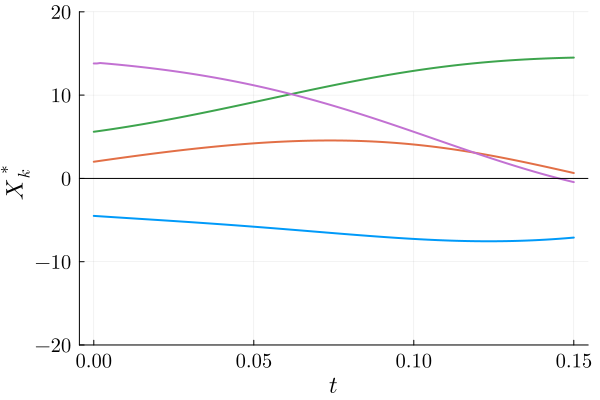

In [22]:
plot(ts, CS.X_array',
    label=[L"$X^\ast_1$" L"$X_2^\ast$" L"$X_3^\ast$" L"$X_4^\ast$"], legend=false, lw=2,
    xlabel=L"$t$", ylabel = L"$X_k^\ast$", ylimits=(-20,20))
hline!([0], color=:black)
# savefig("det_series.png")

In [28]:
CS.X_array[:,2]

4-element Vector{Float64}:
 -4.52518
  2.0549
  5.652056412382
 13.8

In [9]:
mutable struct ctrl_state_cost
    # Model control parameters
    X0::Vector{Float64}
    
    # Variables
    X::Vector{Float64}
    dX::Vector{Float64}
    dXm1::Vector{Float64}
    dXm2::Vector{Float64}
    
    # Data in time array
    X_array::Matrix{Float64}
    
    # Objective Function
    J0::Float64
end

In [10]:
function init_cost(N_t, dt, K, F, XFO, X0)
    # Memory allocation
    X = zeros(Float64, K)
    dX = zeros(Float64, K)
    dXm1 = zeros(Float64, K)
    dXm2 = zeros(Float64, K)
    X_array = zeros(Float64, K, N_t+1)

    # Set intial conditions for X, X_array, XFO, J0
    X .= X0
    X_array[:, 1] = X0
    J0 = 0
    
    # Initialize structs
    su = setup(N_t, dt, K, F, XFO)
    csc = ctrl_state_cost(X0, X, dX, dXm1, dXm2, X_array, J0)
    
    return su, csc
end

init_cost (generic function with 1 method)

In [11]:
# function forward_model_cost(N_t, dt, K, F, X, XF, J0)
    
#     cost = init_cost(N_t, dt, K, F, X, XFO, J0)

#     dX = cost.dX
#     dXm1 = cost.dXm1
#     dXm2 = cost.dXm2
#     X_array = cost.X_array
    
#     for step in 1:2
#         euler_step(dt, K, F, X, dX, dXm1, dXm2)
#         X_array[:, step+1] = X
#     end

#     for step in 3:N_t
#         ab3_step(dt, K, F, X, dX, dXm1, dXm2)
#         X_array[:, step+1] = X
#     end

#     J0 = dot(X - XFO, X - XFO)
    
#     return X_array, J0
# end

function J(su,csc)
    forward_model(su, csc)

    csc.J0 = dot(csc.X - su.XFO, csc.X - su.XFO)
    
    return nothing
end



J (generic function with 1 method)

In [17]:
XFO = [2.32, 2.25, 15.48, -1.96] .+ 0.1

X0 = [ -4.5, 2.0, 5.6, 13.8]

# Model parameters
N_t = 150
dt = 0.001
ts = range(; start=0, step = dt, length=N_t+1)
K = 4
F = 20.
SU, CSC = init_cost(N_t, dt, K, F, XFO, X0)
@time J(SU, CSC)

CSC

# Enzyme.autodiff(Reverse, J, Const(SU), Duplicated(CSC,dCSC))
# dCSC

  0.000056 seconds (302 allocations: 4.875 KiB)


ctrl_state_cost([-4.5, 2.0, 5.6, 13.8], [-7.104621309448463, 0.6457360341853148, 14.502671832847598, -0.44627079248747237], [32.01115875457809, -86.71221833265017, 9.806047620553729, -93.71579946085177], [32.01115875457809, -86.71221833265017, 9.806047620553729, -93.71579946085177], [32.01115875457809, -86.71221833265017, 9.806047620553729, -93.71579946085177], [-4.5 -4.52518 … -7.13781054291996 -7.104621309448463; 2.0 2.0549 … 0.7326161622704921 0.6457360341853148; 5.6 5.652056412382 … 14.493489236484402 14.502671832847598; 13.8 13.8 … -0.3541452773654424 -0.44627079248747237], 96.78219300548811)

In [18]:
# XFO = [2.32, 2.25, 15.48, -1.96] .+ 0.001

# X0 = [ -4.5+10e-10, 2.0, 5.6, 13.8]

# # Model parameters
# N_t = 150
# dt = 0.001
# ts = range(; start=0, step = dt, length=N_t+1)
# K = 4
# F = 20.
# SU, CSC = init_cost(N_t, dt, K, F, XFO, X0)

# # dSU, dCSC = init_cost(N_t, dt, K, F, XFO, X0)
# # Enzyme.autodiff(Reverse, J, Const(SU), Duplicated(CSC,dCSC))
# J(SU, CSC)
# CSC

In [19]:
(96.78219300131676-96.78219300548811)/(10e-10)

-4.17135481711739

In [20]:
XFO = [2.32, 2.25, 15.48, -1.96] .+ 0.1

X0 = [ -4.5, 2.0, 5.6, 13.8]

# Model parameters
N_t = 150
dt = 0.001
ts = range(; start=0, step = dt, length=N_t+1)
K = 4
F = 20.
SU, CSC = init_cost(N_t, dt, K, F, XFO, X0)

dSU, dCSC = init_cost(N_t, dt, K, F, XFO, X0)
dCSC.X0 = zeros(Float64, K)
dCSC.X = zeros(Float64, K)
dCSC.dX = zeros(Float64, K)
dCSC.dXm1 = zeros(Float64, K)
dCSC.dXm2 = zeros(Float64, K)
dCSC.X_array = zeros(Float64, K, N_t+1)
dCSC.J0 = 1.0

@time Enzyme.autodiff(Reverse, J, Const(SU), Duplicated(CSC,dCSC))
dCSC

  0.000627 seconds (5.66 k allocations: 298.250 KiB)


ctrl_state_cost([0.0, 0.0, 0.0, 0.0], [-4.171268274241895, -20.391500904913894, 11.586776600829841, 6.43232713075062], [0.0, 0.0, 0.006508277811813009, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 0.0)

In [16]:
(49.72079812099719-47.00304739251808)/10^(-7)

2.71775072847911e7